In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX
!pip install faiss-gpu

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

In [ ]:
import pandas as pd
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

from tqdm.autonotebook import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

import typing as tp
import faiss
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from functools import partial
import shutil

np.random.seed(31337)

## Нейросетевой отборщик кандидатов
* Нужен, чтобы быстро найти кандидатов для юзера
* Обучается с помощью лосса, который учитывает близость эмбеддингов, а не скоры

#### Проблема:
Допустим, мы обучаем модель, которая ранжирует кандидатов. Отскорить всех кандидатов в real-time мы сможем за O(N). Это не подходит, если кандидатов очень много. Поэтому будем использовать приближенный поиск соседей (LSH, FAISS etc). При этом соседей мы будем находить по расстоянию между вектором юзера и векторами кандиадтов.

### Решение:
Давайте обучим отдельную модель -- отборщика кандидатов -- которая будет качественно искать ближайших соседей. Для этого смоделируем релевантность с помощью любой метрики, отражающей близость векторов.



### DSSM:
[DSSM](https://kishorepv.github.io/DSSM/) модель "сближает" эмбеддинги юзера и позитивных айтемов и "раздвигает" эмбеддинги юзера и негативных айтемов.

#### Архитектура:
1.   **ItemModel**: FF нейросеть, которая маппит фичи айтема в латентное пространство модели
2.   **UserModel**: FF нейросеть, которая маппит фичи юзера в латентное пространство модели  
3.   **Loss**: Triplet loss

В кчаестве фичей айтемов будем использовать доступные нам фичи: популярность, жанр. В качестве фичей юзеров будем использовать multi-hot вектора из матрицы интеракций.

Если фичей айтемов и юзеров нет, то можно сделать one-hot кодирование, имея айди юзера и айтемов.


### Triplet loss

$${\displaystyle {\mathrm {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}_{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}_{2}+\alpha ,0\right)}$$

${f}(A)$ - эмбеддинг юзера,

${f}(P)$ - эмбеддинг позитивного айтема,

${f}(N)$ - эмбеддинг негативного айтема

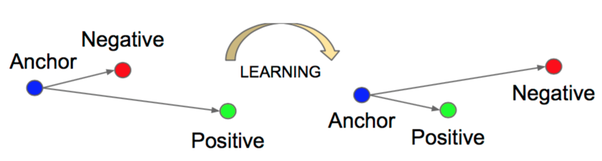

### Сбор данных
* Триплеты: юзер, позитивный айтем, негативный айтем
* Фичи юзера: матрица интеракций
* Фичи айтемов: ohe категориальные фичи

In [ ]:
# p = "/gdrive/MyDrive/RecSys_Data/Week5Seminar/ok_data"
# dfs = list()

# for f in os.listdir("/gdrive/MyDrive/RecSys_Data/Week5Seminar/ok_data"):
#   dfs.append(pd.read_json(os.path.join(p, f) + "/data.json", lines=True))

# pd.concat(dfs).reset_index().drop("index", axis=1).to_csv("/gdrive/MyDrive/RecSys_Data/Week5Seminar/500kfeedbacks.csv")

In [ ]:
NUM_TRACKS = 50000
NUM_USERS = 10000
NUM_GENRES = 154

DUMMY_TRACK = 50000
DUMMY_USER = 10000
DUMMY_GENRE = 0

POSITIVE_PLAY_THRESHOLD = 0.7
TRACK_MIN_OCCURENCE = 5
PLAY_HISTORY_LENGTH = 30

In [ ]:
data =  pd.read_csv("/gdrive/MyDrive/RecSys_Data/Week5Seminar/500kfeedbacks.csv")
track_metadata = pd.read_json("/gdrive/MyDrive/RecSys_Data/Week5Seminar/tracks.json", lines=True).drop_duplicates(subset=["track"])

Отберем позитивные интеракции для фичей юзера

In [ ]:
positive_interactions = data[data["time"] > POSITIVE_PLAY_THRESHOLD].copy()

track_counts = positive_interactions.groupby("track").size()
tracks_with_enough_feedback = set(track_counts[track_counts >= TRACK_MIN_OCCURENCE].index.values)

filtered_interactions = positive_interactions[positive_interactions["track"].isin(tracks_with_enough_feedback)]

len(filtered_interactions), len(tracks_with_enough_feedback)

In [ ]:
interactions_matrix = pd.pivot_table(filtered_interactions, values="time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions_matrix.shape))
print("Sparsity=" + str((interactions_matrix != 0).values.sum() / interactions_matrix.size))

Отберем фичи айтемов: популярность и жанр

In [ ]:
item_features = track_metadata[["track", "pop", "genre"]]

total_genres = item_features["genre"].apply(len).max()
max_genre = item_features["genre"].apply(max).max()
min_genre = item_features["genre"].apply(min).min()


def pad_genre(lst, size, val):
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

item_features['genre'] = item_features['genre'].apply(lambda x: pad_genre(x, total_genres, DUMMY_GENRE))

print("Total genres: ", total_genres)
print("Genre max: ", max_genre)
print("Genre min: ", min_genre)

In [ ]:
item_features

Соберем трейн сразу по тройкам объектов:

uid, iid_pos, iid_neg

* pos - позитивный айтем из сессиии
* neg - случайный айтем из всего каталога

In [ ]:
NUM_NEGATIVE_SAMPLES = 30

triplets = filtered_interactions[["user", "track"]].rename(columns={"track": "positive"})
triplets =  pd.concat([triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
triplets["negative"] = np.random.choice(range(NUM_TRACKS), len(triplets))

Разобьем тройки на train, val, test

In [ ]:
rng = np.random.random(len(triplets))
train_data = triplets[rng < 0.8]
val_data = triplets[(rng >= 0.8) & (rng < 0.9)]
test_data = triplets[rng >= 0.9]

len(train_data), len(val_data), len(test_data)

Для каждого пользака выпишем треки которые он прослушал

In [ ]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

play_history = triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['positive'].tolist(), PLAY_HISTORY_LENGTH, NUM_TRACKS).tolist()
))

play_history = play_history.reindex(range(NUM_USERS), fill_value=[NUM_TRACKS] * PLAY_HISTORY_LENGTH)
play_history = np.stack(play_history.values)

In [ ]:
play_history

### Создаем датасет для оубчения

Он должен возвращать 3 тензора:

*   user_feaures
*   item_features_pos
*   item_features_neg



In [ ]:
class DSSMTensorTrainDataset(td.Dataset):
  def __init__(self, item_features: pd.DataFrame, play_history: np.array, triplets: pd.DataFrame):
    users = triplets["user"].values
    positives = triplets["positive"].values
    negatives = triplets["negative"].values

    # выкидываем позитивные / негативные взаимодействия из юзерской истории прослдушек
    listened_tracks = play_history[users]
    listened_tracks[listened_tracks == positives.reshape(-1, 1)] = DUMMY_TRACK
    listened_tracks[listened_tracks == negatives.reshape(-1, 1)] = DUMMY_TRACK

    self.listened_tracks = torch.from_numpy(listened_tracks).long()

    self.pos_item_track = torch.from_numpy(item_features['track'].loc[positives].values).long()
    self.pos_item_genre = torch.from_numpy(np.stack(item_features['genre'].loc[positives].values)).long()
    self.pos_item_pop = torch.from_numpy(item_features['pop'].loc[positives].values).double()

    self.neg_item_track = torch.from_numpy(item_features['track'].loc[negatives].values).long()
    self.neg_item_genre = torch.from_numpy(np.stack(item_features['genre'].loc[negatives].values)).long()
    self.neg_item_pop = torch.from_numpy(item_features['pop'].loc[negatives].values).double()

  def __getitem__(self, idx):
    return self.__getitems__([idx])

  def __getitems__(self, idxs: list):
    return {
        "listened_tracks": self.listened_tracks[idxs],
        "positive": {
            "track": self.pos_item_track[idxs],
            "genre": self.pos_item_genre[idxs],
            "pop": self.pos_item_pop[idxs]
        },
        "negative": {
            "track": self.neg_item_track[idxs],
            "genre": self.neg_item_genre[idxs],
            "pop": self.neg_item_pop[idxs]
        }
    }

  def __len__(self):
    # возвращаем длину любого из массивов
    return len(self.listened_tracks)


class DSSMTensorInferenceUsersDataset(td.Dataset):
  def __init__(self, play_history: np.array):
    self.play_history = torch.from_numpy(play_history).long()

  def __getitem__(self, idx):
    return self.__getitems__([idx])

  def __getitems__(self, idxs: list):
    return self.play_history[idxs]

  def __len__(self):
    return len(self.play_history)


class DSSMTensorInferenceItemsDataset(td.Dataset):
  def __init__(self, item_features: pd.DataFrame):
    self.track = torch.from_numpy(item_features['track'].values).long()
    self.genre = torch.from_numpy(np.stack(item_features['genre'].values)).long()
    self.pop = torch.from_numpy(item_features['pop'].values).double()

  def __getitem__(self, idx):
    return self.__getitems__([idx])

  def __getitems__(self, idxs: list):
    return {
        "track": self.track[idxs],
        "genre": self.genre[idxs],
        "pop": self.pop[idxs]
    }

  def __len__(self):
    # возвращаем длину любого из массивов
    return len(self.track)

In [ ]:
class DSSMDataModule(pl.LightningDataModule):
  def __init__(self, train_triplets, val_triplets, test_triplets, item_features, play_history, batch_size=2048):
    super().__init__()
    self.train_triplets = train_triplets
    self.val_triplets = val_triplets
    self.test_triplets = test_triplets
    self.item_features = item_features
    self.play_history = play_history
    self.batch_size = batch_size

  def _collect_data(self, triplets):
    return DSSMTensorTrainDataset(self.item_features, self.play_history, triplets)

  def prepare_data(self, stage=None):
    if stage == "fit" or stage is None:
      self.train_dataset = self._collect_data(self.train_triplets)
      self.val_dataset = self._collect_data(self.val_triplets)
    elif stage == "test" or stage is None:
      self.test_dataset = self._collect_data(self.test_triplets)

  def train_dataloader(self):
    return td.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, collate_fn=lambda x: x)

  def val_dataloader(self):
    return td.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: x)

  def test_dataloader(self):
    return td.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, collate_fn=lambda x: x)

# Архитектура DSSM

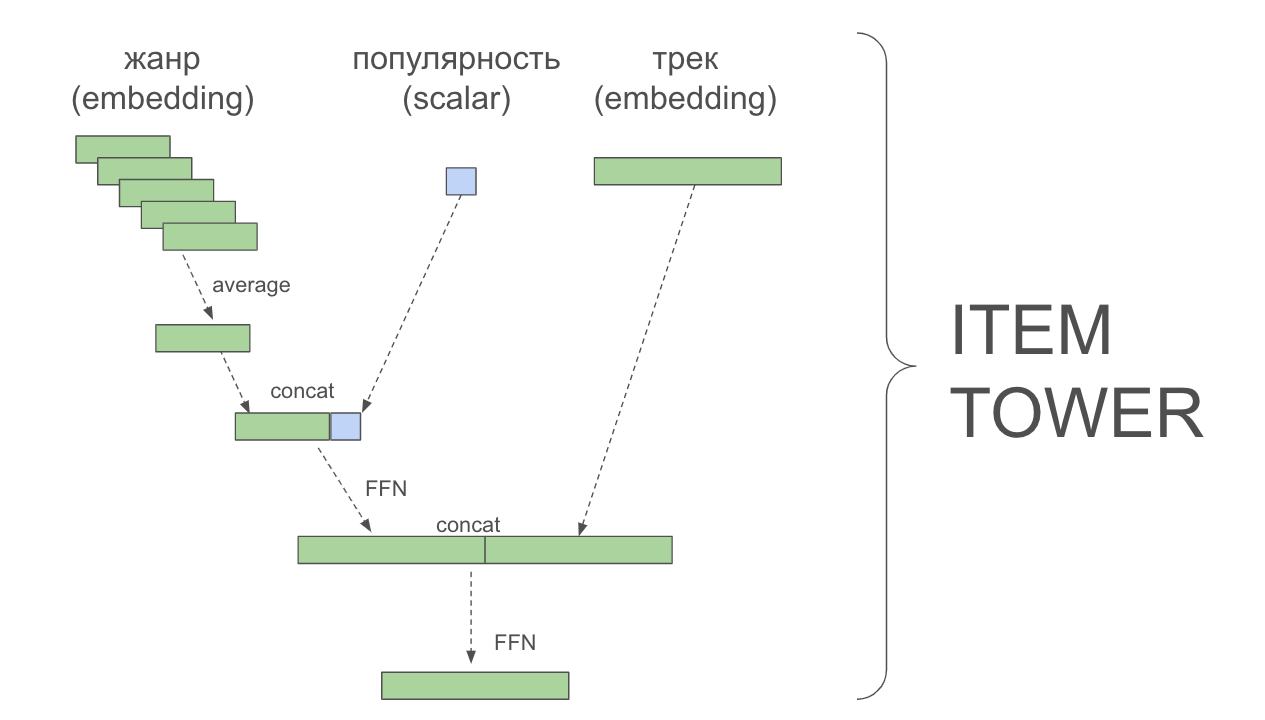

In [ ]:
class ItemTower(nn.Module):
    def __init__(self, n_factors: int):
        super().__init__()
        self.genre_embedding_dim = 10
        self.track_embeddings = nn.Embedding(NUM_TRACKS+1, n_factors)
        self.genre_embeddings = nn.EmbeddingBag(NUM_GENRES+1, self.genre_embedding_dim, padding_idx=DUMMY_GENRE)
        self.dense_layer = nn.Linear(self.genre_embedding_dim + 1, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors * 2, n_factors, bias=False)

    def forward(self, item_features: dict) -> torch.Tensor:
        track = item_features['track']
        genre = item_features['genre']
        pop = item_features['pop']

        track_emb = self.track_embeddings(track)
        genre_emb = self.genre_embeddings(genre) # averaging
        pop_emb = pop.view(-1, 1)

        pop_genre = torch.concat([pop_emb, genre_emb], axis=1)
        features = F.relu(self.dense_layer(pop_genre))

        features_combined = torch.concat([features, track_emb], axis=1)

        return self.output_layer(features_combined)

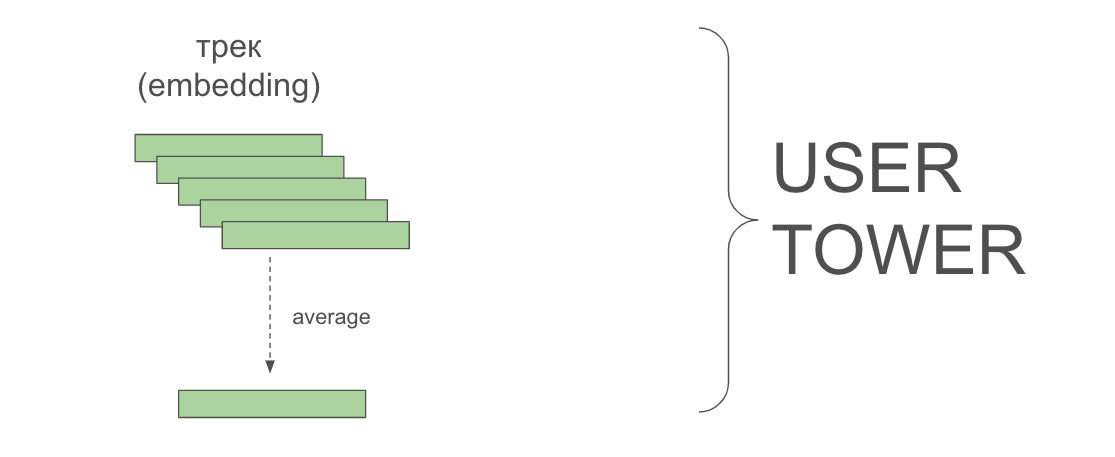

In [ ]:
class UserTower(nn.Module):
    def __init__(self, n_factors: int):
        super().__init__()
        self.track_embeddings = nn.EmbeddingBag(NUM_TRACKS+1, n_factors, padding_idx=DUMMY_TRACK)

    def forward(self, listened_tracks: torch.Tensor) -> torch.Tensor:
        return self.track_embeddings(listened_tracks)

DSSM модель

In [ ]:
class DSSM(pl.LightningModule):
    def __init__(
        self,
        item_number: int,
        embedding_dim: int = 100,
        lr: float = 1e-3,
        triplet_loss_margin: float = 0.4,
        weight_decay: float = 1e-6,
        log_to_prog_bar: bool = True,
    ) -> None:
        super().__init__()
        self.lr = lr
        self.triplet_loss_margin = triplet_loss_margin
        self.weight_decay = weight_decay
        self.log_to_prog_bar = log_to_prog_bar
        self.item_net = ItemTower(embedding_dim)
        self.user_net = UserTower(embedding_dim)

    def forward(self, batch) -> tp.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        anchor = self.user_net(batch['listened_tracks'])
        pos = self.item_net(batch['positive'])
        neg = self.item_net(batch['negative'])

        return anchor, pos, neg

    def _step(self, batch: dict, batch_idx, metric, prog_bar=False):
        anchor, positive, negative = self(batch)
        loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.triplet_loss_margin)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "train_loss")

    def validation_step(self, batch: dict, batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "val_loss", self.log_to_prog_bar)

    def test_step(self, batch, batch_idx, prog_bar=False):
        return self._step(batch, batch_idx, "test_loss", self.log_to_prog_bar)

    def inference(self, dataloader: td.DataLoader[tp.Any], mode: str = "item") -> np.ndarray:
        batches = []

        self.eval()
        with torch.no_grad():
          for batch in dataloader:
              if mode == "user":
                embeddings_batch = self.user_net(batch)
              elif mode == "item":
                embeddings_batch = self.item_net(batch)

              batches.append(embeddings_batch)

        embeddings = torch.cat(batches, dim=0).cpu().numpy()
        return embeddings

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

Конфигурируем обучение

In [ ]:
EMBEDDING_DIM = 64

In [ ]:
data_module = DSSMDataModule(train_data, val_data, test_data, item_features, play_history)
net = DSSM(item_number=NUM_TRACKS, embedding_dim=EMBEDDING_DIM).double()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ])

In [ ]:
trainer.fit(
    net,
    data_module
)

In [ ]:
shutil.move(checkpoint_callback.best_model_path, "/gdrive/MyDrive/RecSys_Data/Week5Seminar/dssm.ckpt")

In [ ]:
best_model = DSSM.load_from_checkpoint("/gdrive/MyDrive/RecSys_Data/Week5Seminar/dssm.ckpt", item_number=NUM_TRACKS, embedding_dim=EMBEDDING_DIM)

Инферим модель

In [ ]:
users_dataset = DSSMTensorInferenceUsersDataset(play_history)
users_dataloader = td.DataLoader(users_dataset, batch_size=1024, shuffle=False, collate_fn=lambda x: x)
users_embeddings = best_model.cpu().double().inference(users_dataloader, mode='user')

In [ ]:
items_dataset = DSSMTensorInferenceItemsDataset(item_features)
items_dataloader = td.DataLoader(items_dataset, batch_size=1024, shuffle=False, collate_fn=lambda x: x)
items_embeddings = best_model.cpu().double().inference(items_dataloader, mode='item')

In [ ]:
items_embeddings.shape, users_embeddings.shape

In [ ]:
gpu_res = faiss.StandardGpuResources()
index_flat = faiss.index_factory(items_embeddings.shape[1], "Flat", faiss.METRIC_L2)

#index = faiss.index_cpu_to_gpu(gpu_res, 0, index_flat)
index = index_flat
index.add(items_embeddings.astype('float32'))

In [ ]:
k = 100
with open("/gdrive/MyDrive/RecSys_Data/Week5Seminar/recommendations_dssm.json", "w") as rf:
    for user, user_emb in tqdm(enumerate(users_embeddings), total=len(users_embeddings)):
      dists, neighbours = index.search(user_emb.astype('float32')[np.newaxis, :], k)
      recommendation = {
            "user": int(user),
            "tracks": neighbours.flatten().tolist()
        }
      rf.write(json.dumps(recommendation) + "\n")

Записываем эмбеддинги и логи обучения

In [ ]:
writer = tb.SummaryWriter(comment='dssm_embeddings', log_dir="/gdrive/MyDrive/RecSys_Data/Week5Seminar/tb")
writer.add_embedding(items_embeddings, metadata=list(track_metadata[["artist", "title"]].itertuples(index=False, name=None)), tag="DSSM", metadata_header=["artist", "title"])
writer.close()

In [ ]:
!cp -r /content/lightning_logs /gdrive/MyDrive/RecSys_Data/Week5Seminar/lightning_logs

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/gdrive/MyDrive/RecSys_Data/Week5Seminar/lightning_logs --port 5124

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/gdrive/MyDrive/RecSys_Data/Week5Seminar/tb --port 5123